In [70]:
# import relevant libraries

# basic libraries
import pandas as pd
import numpy as np
from collections import Counter
import re

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

# machine learning libraries
from sklearn import tree, metrics, model_selection, linear_model, ensemble, preprocessing, feature_extraction, feature_selection

# data collection libraries
import requests
from selenium import webdriver
import bs4
import imdbpie
import json

%matplotlib inline

# Identify: Problem Statement & Goals

**Using data from IMDB, can we build a model that predicts movie ratings based on certain inputs?**

- Predict movie ratings using information about the movie (e.g. genre, length of movie etc.)
- What are the factors that affect movie rating?

# Acquire: Query IMDB, write results, scrape IMDB

## Basic information using OMDBAPI, requests and BeautifulSoup

In [2]:
r2 = requests.get("http://www.imdb.com/chart/top")
id_list = re.findall("tt[0-9]{7,8}", r2.content)

# set removes duplicates
# change it back to a list so we can iterate through it later
id_list = list(set(id_list))

In [3]:
id_list[:5]

['tt2582802', 'tt0047478', 'tt0082971', 'tt0050212', 'tt0848228']

In [4]:
# OMDb API URL
api_url = "http://www.omdbapi.com/?i={}&plot=full&r=json"

In [5]:
# path to phantomjs
phan_path = "//Applications/phantomjs"

In [6]:
# Create a function to get the data for each movie
# into a format we can work with
def get_content(id_num):
    r = requests.get(api_url.format(id_num))
    tmp = json.loads(r.text)
    return tmp

In [7]:
# Populate our data
df = pd.DataFrame([get_content(i) for i in id_list])

In [8]:
df.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,USA,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,https://images-na.ssl-images-amazon.com/images...,R,15 Oct 2014,True,107 min,Whiplash,movie,Damien Chazelle,2014,tt2582802,8.5,"413,720"
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Japan,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",https://images-na.ssl-images-amazon.com/images...,UNRATED,19 Nov 1956,True,207 min,Seven Samurai,movie,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",1954,tt0047478,8.7,"232,249"
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,USA,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,https://images-na.ssl-images-amazon.com/images...,PG,12 Jun 1981,True,115 min,Raiders of the Lost Ark,movie,"Lawrence Kasdan (screenplay), George Lucas (st...",1981,tt0082971,8.5,"671,034"
3,"William Holden, Alec Guinness, Jack Hawkins, S...",Won 7 Oscars. Another 23 wins & 7 nominations.,"UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",N/A,After settling his differences with a Japanese...,https://images-na.ssl-images-amazon.com/images...,PG,14 Dec 1957,True,161 min,The Bridge on the River Kwai,movie,"Pierre Boulle (novel), Carl Foreman (screenpla...",1957,tt0050212,8.2,"151,604"
4,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Nominated for 1 Oscar. Another 34 wins & 75 no...,USA,Joss Whedon,"Action, Sci-Fi, Thriller","English, Russian",69,"Nick Fury is the director of S.H.I.E.L.D., an ...",https://images-na.ssl-images-amazon.com/images...,PG-13,04 May 2012,True,143 min,The Avengers,movie,"Joss Whedon (screenplay), Zak Penn (story), Jo...",2012,tt0848228,8.1,"1,010,033"


## Add gross revenue

In [9]:
# Create a function to pull Gross Earnings information
# and return np.nan if it's not available
def get_gross(id_num):
    r = requests.get("http://www.imdb.com/title/{}/".format(id_num))
    soup = bs4.BeautifulSoup(r.text, "lxml")
    try:
        for i in soup.findAll("div", class_="txt-block"):
            for j in i.findAll("h4", class_="inline"):
                if "Gross" in j.text:
                    text = j.parent.text.split()[1]
                    num = text.replace(",", "").strip("$")
                    return float(num)
    except:
        return np.nan

In [10]:
# Create a column in the dataframe for Gross Earnings
df["Gross_earnings"] = df["imdbID"].map(get_gross)

In [11]:
df = df.replace("", np.nan)
df = df.replace("N/A", np.nan)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 21 columns):
Actors            250 non-null object
Awards            246 non-null object
Country           250 non-null object
Director          250 non-null object
Genre             250 non-null object
Language          249 non-null object
Metascore         169 non-null object
Plot              250 non-null object
Poster            248 non-null object
Rated             249 non-null object
Released          249 non-null object
Response          250 non-null object
Runtime           250 non-null object
Title             250 non-null object
Type              250 non-null object
Writer            250 non-null object
Year              250 non-null object
imdbID            250 non-null object
imdbRating        250 non-null object
imdbVotes         250 non-null object
Gross_earnings    184 non-null float64
dtypes: float64(1), object(20)
memory usage: 41.1+ KB


In [13]:
df.to_csv("imdb_scraped.csv", encoding="utf-8")

# Mine: Rename & describe data

In [648]:
df2 = df.copy()

In [649]:
df2["Date"] = pd.to_datetime(df2["Released"])

In [650]:
df2.Title[df2.Date.isnull()]

73    The Gold Rush
Name: Title, dtype: object

In [651]:
df2.set_value(df2.Date.isnull(), "Released","26 June 1925");
df2.set_value(df2["Title"] == "The Gold Rush", "Date", pd.to_datetime(df2["Released"][df2["Title"] == "The Gold Rush"]));

In [652]:
df2["Runtime_min"] = df2["Runtime"].map(lambda x: float(x.split()[0]))

In [653]:
df2["Year"] = df2["Year"].astype(int)

In [654]:
df2["Month"] = df2["Date"].map(lambda x: x.month)

In [655]:
df2["imdbRating"] = df2["imdbRating"].astype(float)

In [656]:
df2["imdbVotes"] = df2["imdbVotes"].map(lambda x: float(x.replace(",", "")))

In [657]:
def oscars_won(i):
    try:
        i_list = i.split()
        i_list = [x.strip(".") for x in i_list]
        if "Oscars" in i_list and i_list[i_list.index("Oscars")-2] == "Won":
            return float(i_list[i_list.index("Oscars")-1])
        elif "Oscar" in i_list and  i_list[i_list.index("Oscar")-2] == "Won":
            return float(i_list[i_list.index("Oscars")-1])
        else:
            return 0
    except:
        return 0

In [658]:
df2["Oscars_won"] = df2["Awards"].map(oscars_won)

In [659]:
oscars_won(df2["Awards"][0])

3.0

In [660]:
df2.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Writer,Year,imdbID,imdbRating,imdbVotes,Gross_earnings,Date,Runtime_min,Month,Oscars_won
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,USA,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,https://images-na.ssl-images-amazon.com/images...,R,...,Damien Chazelle,2014,tt2582802,8.5,413720.0,13092000.0,2014-10-15,107.0,10,3.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Japan,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",https://images-na.ssl-images-amazon.com/images...,UNRATED,...,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",1954,tt0047478,8.7,232249.0,269061.0,1956-11-19,207.0,11,0.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,USA,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,https://images-na.ssl-images-amazon.com/images...,PG,...,"Lawrence Kasdan (screenplay), George Lucas (st...",1981,tt0082971,8.5,671034.0,242374454.0,1981-06-12,115.0,6,4.0
3,"William Holden, Alec Guinness, Jack Hawkins, S...",Won 7 Oscars. Another 23 wins & 7 nominations.,"UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",NaN,After settling his differences with a Japanese...,https://images-na.ssl-images-amazon.com/images...,PG,...,"Pierre Boulle (novel), Carl Foreman (screenpla...",1957,tt0050212,8.2,151604.0,27200000.0,1957-12-14,161.0,12,7.0
4,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Nominated for 1 Oscar. Another 34 wins & 75 no...,USA,Joss Whedon,"Action, Sci-Fi, Thriller","English, Russian",69,"Nick Fury is the director of S.H.I.E.L.D., an ...",https://images-na.ssl-images-amazon.com/images...,PG-13,...,"Joss Whedon (screenplay), Zak Penn (story), Jo...",2012,tt0848228,8.1,1010033.0,623279547.0,2012-05-04,143.0,5,0.0


In [661]:
# Let"s consider the language the movie is available in
all_languages = []
for i in df2["Language"]:
    lang_list = str(i).split(",")
    all_languages.extend([j.strip() for j in lang_list])
language_counts = Counter(all_languages)

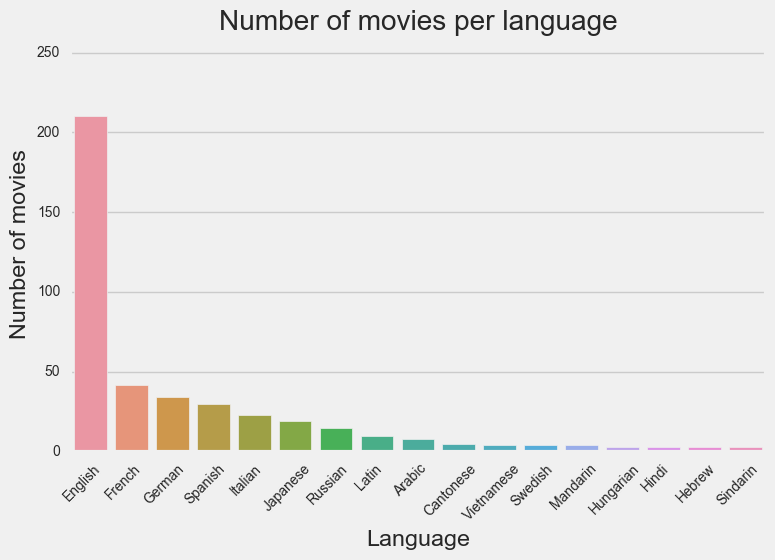

In [662]:
# Let's look at the majority languages
language_df = pd.DataFrame([(i,j) for i,j in language_counts.items()], columns=["Language", "Count"])
language_df.sort_values(by="Count", ascending=False, inplace=True)
more_than_2 = language_df[language_df["Count"] > 2].reset_index(drop=True)
plt.subplots(figsize=(8,5));
sns.barplot(x="Language", y="Count", data=more_than_2);
plt.xticks([i-0.2 for i in range(len(more_than_2))], more_than_2["Language"],rotation=45);
plt.ylabel("Number of movies");
plt.title("Number of movies per language");
plt.ylim((0,260));

In [663]:
top_10_languages = [i[0] for i in Counter(all_languages).most_common(10)]
top_10_languages

['English',
 'French',
 'German',
 'Spanish',
 'Italian',
 'Japanese',
 'Russian',
 'Latin',
 'Arabic',
 'Cantonese']

In [664]:
# Add language dummies
for i in top_10_languages:
    df2["Language_"+i] = df2["Language"].map(lambda x: 1 if i in str(x) else 0)

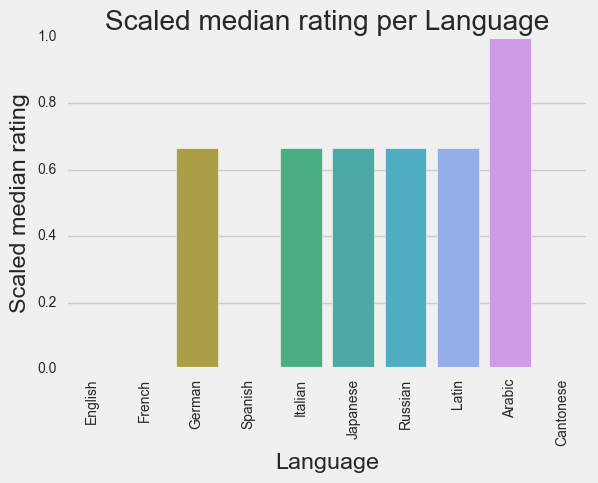

In [836]:
# Let's check out median rating per language
# Note that there will be "double-counting" because some movies have more than one language
language_rating = []
for i in top_10_languages:
    language_rating.append([i,df2["imdbRating"][df2["Language_"+i]==1].median()])

language_rating = pd.DataFrame(language_rating, columns=["Language", "Median_rating"])

scaler2 = preprocessing.MinMaxScaler()
language_rating["Scaled_rating"] = scaler2.fit_transform(language_rating["Median_rating"].values.reshape(-1,1))

sns.barplot(x="Language", y="Scaled_rating", data=language_rating);
plt.title("Scaled median rating per Language");
plt.ylabel("Scaled median rating");
plt.xticks(rotation="vertical");

In [665]:
country = []
for i in df2["Country"]:
    country.extend(i.split(","))
country_counts = Counter(country)

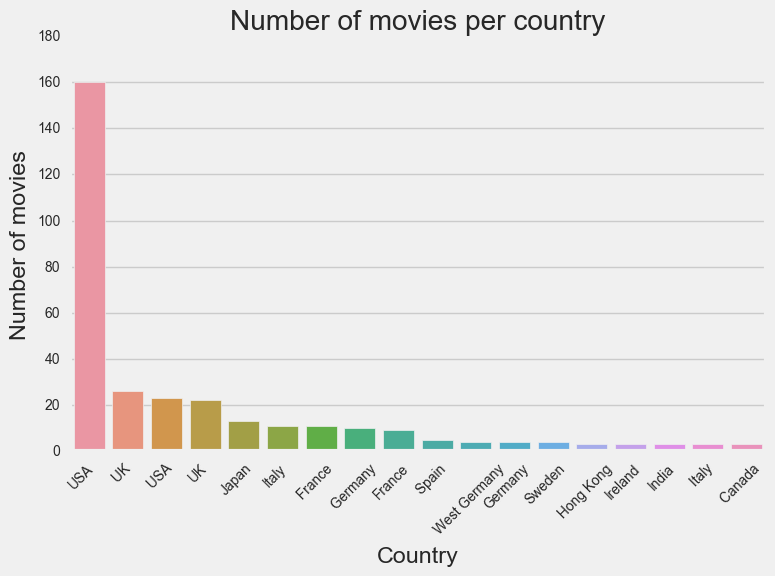

In [666]:
# Let's see how many movies each country has
country_df = pd.DataFrame([(i,j) for i,j in country_counts.items()], columns=["Country", "Count"])
country_df.sort_values(by="Count", ascending=False, inplace=True)
more_than_2 = country_df[country_df["Count"] > 2].reset_index(drop=True)
plt.subplots(figsize=(8,5));
sns.barplot(x="Country", y="Count", data=more_than_2);
plt.xticks([i-0.2 for i in range(len(more_than_2))], more_than_2["Country"],rotation=45);
plt.ylabel("Number of movies");
plt.title("Number of movies per country");
plt.ylim((0,180));

In [667]:
# Let"s consider where the movies are made
# For model simplicity, we'll consider just the top 10 countries
top_10_countries = [i[0] for i in country_counts.most_common(10)]
top_10_countries

[u'USA',
 u' UK',
 u' USA',
 u'UK',
 u'Japan',
 u'Italy',
 u' France',
 u' Germany',
 u'France',
 u' Spain']

In [668]:
for i in top_10_countries:
    df2["Country_"+i] = df2["Country"].map(lambda x: 1 if i in str(x) else 0)

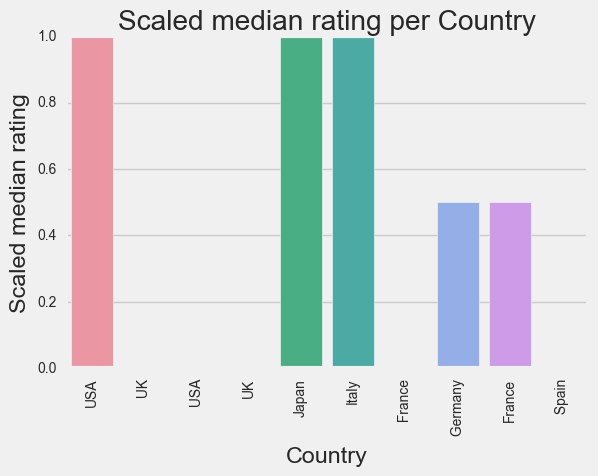

In [838]:
# Let's check out median rating per Country
# Note that there will be "double-counting" because some movies are screened in more than one country
country_rating = []
for i in top_10_countries:
    country_rating.append([i,df2["imdbRating"][df2["Country_"+i]==1].median()])

country_rating = pd.DataFrame(country_rating, columns=["Country", "Median_rating"])

scaler2 = preprocessing.MinMaxScaler()
country_rating["Scaled_rating"] = scaler2.fit_transform(country_rating["Median_rating"].values.reshape(-1,1))

sns.barplot(x="Country", y="Scaled_rating", data=country_rating);
plt.title("Scaled median rating per Country");
plt.ylabel("Scaled median rating");
plt.xticks(rotation="vertical");

In [669]:
df2["Rated"].value_counts()

R            106
PG            37
PG-13         33
NOT RATED     28
APPROVED      18
G             13
UNRATED        9
PASSED         4
M              1
Name: Rated, dtype: int64

In [670]:
# Let's group some of the ratings together
def group_rating(rate):
    if rate in ["R", "PG", "PG-13", "G"]:
        return rate
    else:
        return "OTHER"

In [671]:
df2["Rate_clean"] = df2["Rated"].map(group_rating)

In [672]:
rate_dummies = pd.get_dummies(df2["Rate_clean"])
rate_dummies = rate_dummies.drop("OTHER", axis=1)

In [673]:
df2 = pd.concat([df2, rate_dummies], axis=1)

In [674]:
# Get genre_dummies
genre_list = []
for i in df2["Genre"]:
    genre_list.extend([x.strip() for x in i.split(",")])
genre_list = list(set(genre_list))
genre_list.sort()

In [675]:
for i in genre_list:
    df2["Genre_"+i] = df2["Genre"].apply(lambda x: 1 if i in str(x) else 0)

In [676]:
df2["Type"].value_counts()

movie    250
Name: Type, dtype: int64

In [677]:
df2["Response"].value_counts()

True    250
Name: Response, dtype: int64

In [678]:
df2.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War,Genre_Western
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,USA,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,https://images-na.ssl-images-amazon.com/images...,R,...,0,1,0,0,0,0,0,0,0,0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,Japan,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",https://images-na.ssl-images-amazon.com/images...,UNRATED,...,0,0,0,0,0,0,0,0,0,0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,USA,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,https://images-na.ssl-images-amazon.com/images...,PG,...,0,0,0,0,0,0,0,0,0,0
3,"William Holden, Alec Guinness, Jack Hawkins, S...",Won 7 Oscars. Another 23 wins & 7 nominations.,"UK, USA",David Lean,"Adventure, Drama, War","English, Japanese, Thai",NaN,After settling his differences with a Japanese...,https://images-na.ssl-images-amazon.com/images...,PG,...,0,0,0,0,0,0,0,0,1,0
4,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Nominated for 1 Oscar. Another 34 wins & 75 no...,USA,Joss Whedon,"Action, Sci-Fi, Thriller","English, Russian",69,"Nick Fury is the director of S.H.I.E.L.D., an ...",https://images-na.ssl-images-amazon.com/images...,PG-13,...,0,0,0,0,0,1,0,1,0,0


In [679]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 71 columns):
Actors                250 non-null object
Awards                246 non-null object
Country               250 non-null object
Director              250 non-null object
Genre                 250 non-null object
Language              249 non-null object
Metascore             169 non-null object
Plot                  250 non-null object
Poster                248 non-null object
Rated                 249 non-null object
Released              250 non-null object
Response              250 non-null object
Runtime               250 non-null object
Title                 250 non-null object
Type                  250 non-null object
Writer                250 non-null object
Year                  250 non-null int64
imdbID                250 non-null object
imdbRating            250 non-null float64
imdbVotes             250 non-null float64
Gross_earnings        184 non-null float64
Date       

In [680]:
# To be able to use gross earnings in our model, 
# we'll assume that if the gross earnings information is not available, then the movie earned $0
df2["Gross_earnings"].fillna(0, inplace=True)

In [681]:
# Similarly for metascore
# we'll assume that it's 0 if the information is not available
df2["Metascore"].fillna(0, inplace=True)

In [682]:
# Let's create a column to bin the ratings to below 8.5 and (8.5 and above)
df2["rating_higher_8.5"] = df2["imdbRating"].map(lambda x: 1 if x >= 8.5 else 0)

In [683]:
df2.to_csv("imdb_clean.csv", encoding="utf-8")

# Refine: Visualize data
Bonus: Use multiple data viz tools

In [742]:
df3 = df2.copy()

In [743]:
for i in df3.columns.values:
    print '"'+i+'"'+",",

"Actors", "Awards", "Country", "Director", "Genre", "Language", "Metascore", "Plot", "Poster", "Rated", "Released", "Response", "Runtime", "Title", "Type", "Writer", "Year", "imdbID", "imdbRating", "imdbVotes", "Gross_earnings", "Date", "Runtime_min", "Month", "Oscars_won", "Language_English", "Language_French", "Language_German", "Language_Spanish", "Language_Italian", "Language_Japanese", "Language_Russian", "Language_Latin", "Language_Arabic", "Language_Cantonese", "Country_USA", "Country_ UK", "Country_ USA", "Country_UK", "Country_Japan", "Country_Italy", "Country_ France", "Country_ Germany", "Country_France", "Country_ Spain", "Rate_clean", "G", "PG", "PG-13", "R", "Genre_Action", "Genre_Adventure", "Genre_Animation", "Genre_Biography", "Genre_Comedy", "Genre_Crime", "Genre_Drama", "Genre_Family", "Genre_Fantasy", "Genre_Film-Noir", "Genre_History", "Genre_Horror", "Genre_Music", "Genre_Musical", "Genre_Mystery", "Genre_Romance", "Genre_Sci-Fi", "Genre_Sport", "Genre_Thriller", 

In [744]:
rel_columns = ["rating_higher_8.5","imdbRating", "imdbID", "Title", 
               "Writer", "Actors", "Director", "Plot","Metascore", 
               "Year", "Month", "imdbVotes", "Gross_earnings", 
               "Runtime_min", "Oscars_won", "Language_English", "Language_French", 
               "Language_German", "Language_Spanish", "Language_Italian", "Language_Japanese", 
               "Language_Russian", "Language_Latin", "Language_Arabic", "Language_Cantonese", 
               "Country_USA", "Country_ UK", "Country_ USA", "Country_UK", "Country_Japan", 
               "Country_Italy", "Country_ France", "Country_ Germany", "Country_France", 
               "Country_ Spain", "G", "PG", "PG-13", "R", 
               "Genre_Action", "Genre_Adventure", "Genre_Animation", "Genre_Biography", 
               "Genre_Comedy", "Genre_Crime", "Genre_Drama", "Genre_Family", "Genre_Fantasy", 
               "Genre_Film-Noir", "Genre_History", "Genre_Horror", "Genre_Music", "Genre_Musical", 
               "Genre_Mystery", "Genre_Romance", "Genre_Sci-Fi", "Genre_Sport", "Genre_Thriller", 
               "Genre_War", "Genre_Western"]
num_cat_features = rel_columns[8:]

In [745]:
df3 = df3[rel_columns]

In [746]:
# Scale our continuous colums
# We'll consider year and month as continuous for this
scale_columns = ["Metascore", "Year", "Month", "imdbVotes", "Gross_earnings", "Runtime_min", "Oscars_won"]
scaler = preprocessing.StandardScaler()
scaler.fit(df3[scale_columns])

for i,j in enumerate(scale_columns):
    df3.loc[:,j] = scaler.transform(df3[scale_columns])[:,i]

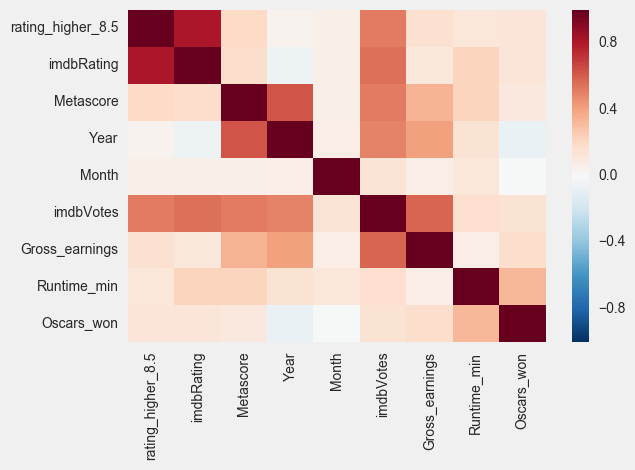

In [747]:
sns.heatmap(df3.iloc[:,:15].corr());

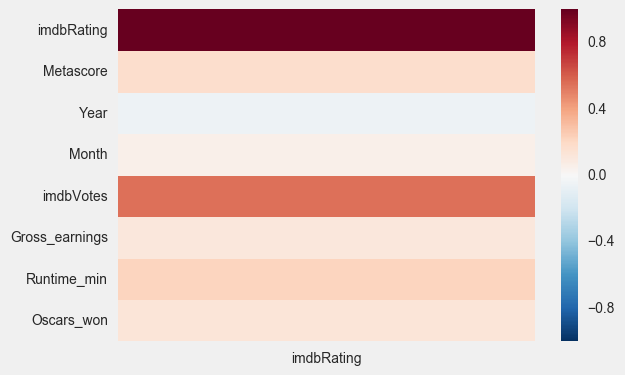

In [748]:
sns.heatmap(df3.iloc[:,:15].corr()[["imdbRating"]].iloc[1:]);

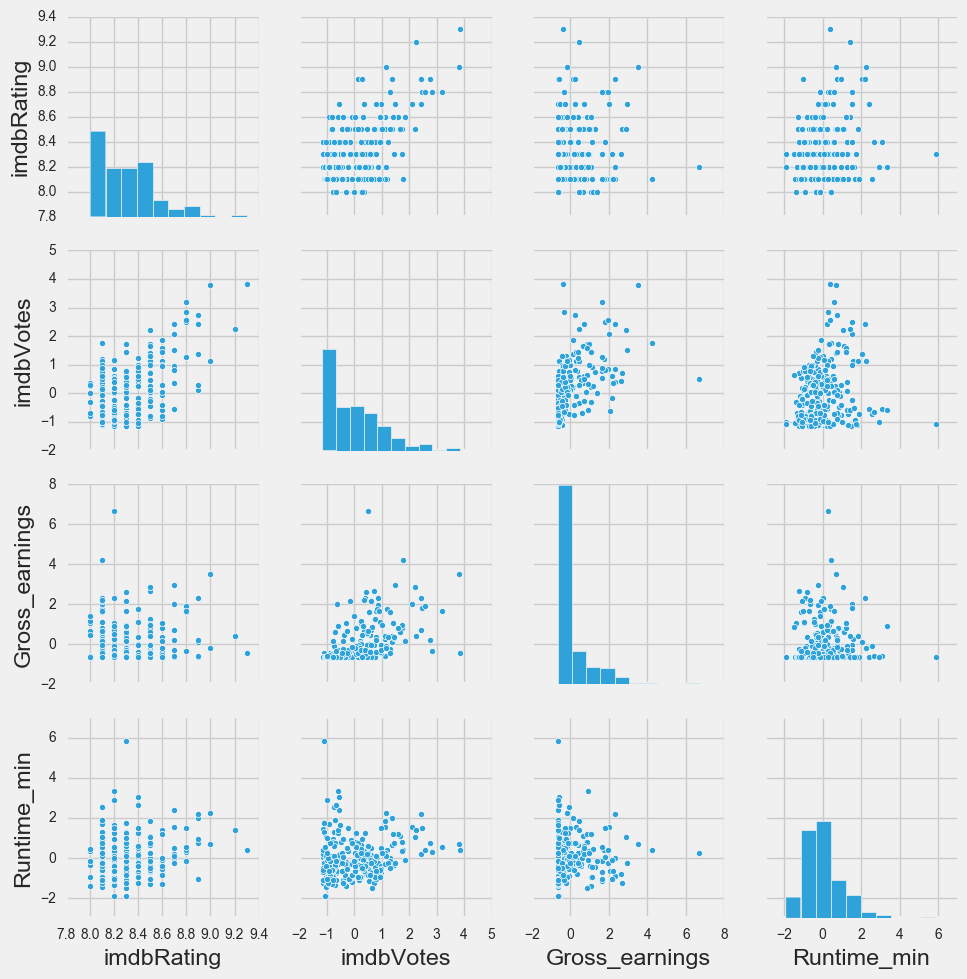

In [749]:
sns.pairplot(df3[["imdbRating", "imdbVotes", "Gross_earnings", "Runtime_min"]]);

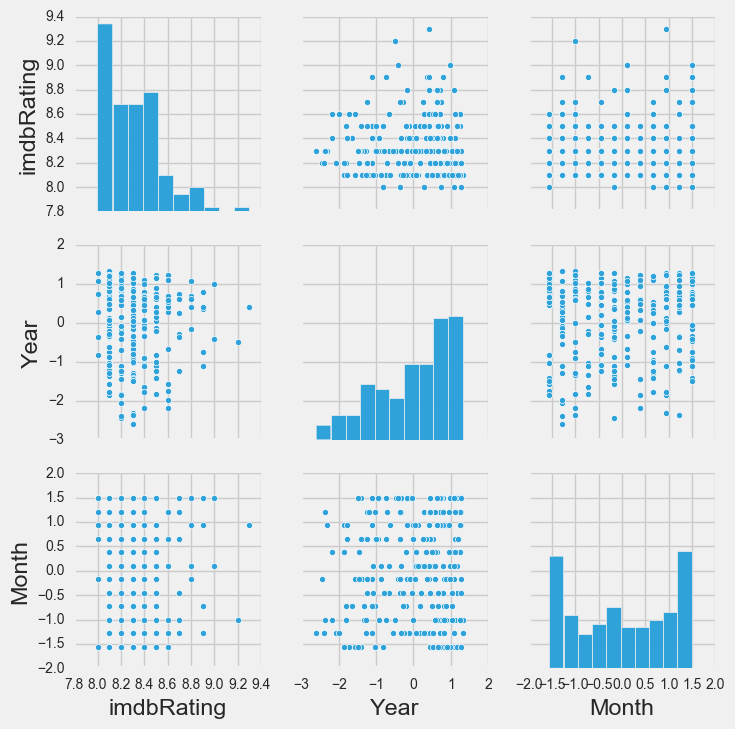

In [750]:
sns.pairplot(df3[["imdbRating", "Year", "Month"]]);

In [751]:
df3.to_csv("imdb_model.csv", encoding="utf-8")

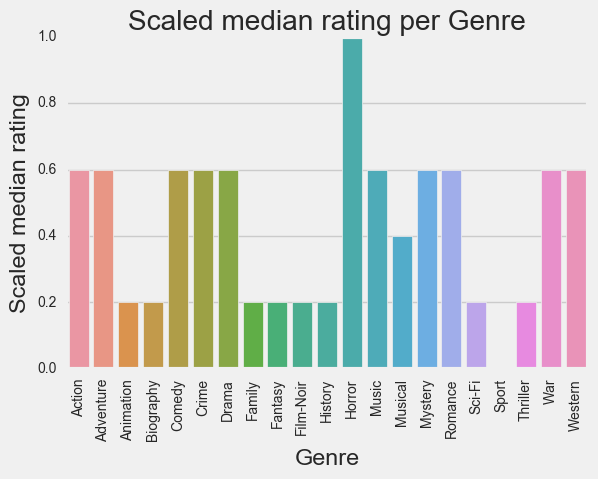

In [830]:
# Let's check out median rating per genre
# Note that there will be "double-counting" because some movies have multiple genres
genre_rating = []
for i in genre_list:
    genre_rating.append([i,df3["imdbRating"][df3["Genre_"+i]==1].median()])

genre_rating = pd.DataFrame(genre_rating, columns=["Genre", "Median_rating"])

genre_scaler = preprocessing.MinMaxScaler()
genre_rating["Scaled_rating"] = genre_scaler.fit_transform(genre_rating["Median_rating"].values.reshape(-1,1))

sns.barplot(x="Genre", y="Scaled_rating", data=genre_rating);
plt.title("Scaled median rating per Genre");
plt.ylabel("Scaled median rating");
plt.xticks(rotation="vertical");

## Adding in text features

In [752]:
df4 = df3.copy()

In [753]:
vectorizer = feature_extraction.text.CountVectorizer(token_pattern=u'(?u)\w+.?\w?.? \w+')
actors_df = pd.DataFrame(vectorizer.fit_transform(df4["Actors"]).todense(), columns = vectorizer.get_feature_names())

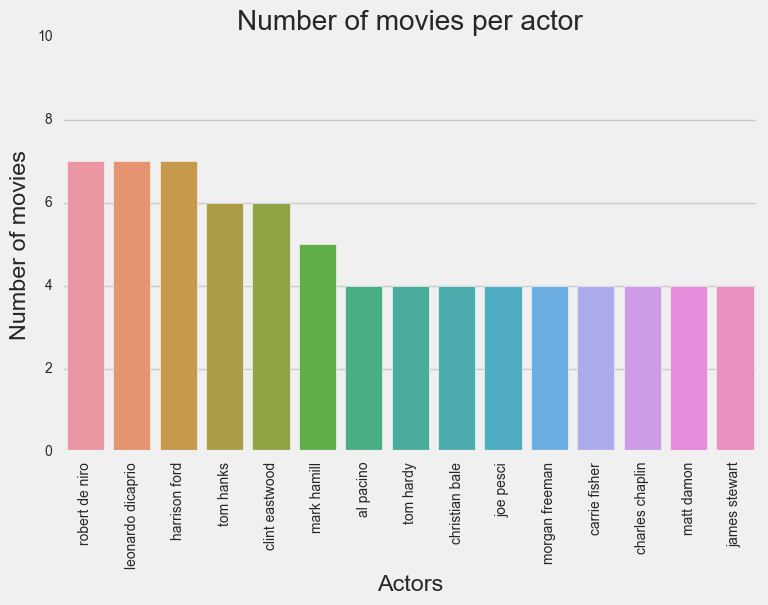

In [828]:
actors_count = pd.DataFrame(actors_df.sum()).reset_index()
actors_count.columns = ["Actors", "Count"]
actors_count.sort_values(by="Count", ascending=False, inplace=True)

more_than = actors_count[actors_count["Count"] > 3].reset_index(drop=True)
plt.subplots(figsize=(8,5));
sns.barplot(x="Actors", y="Count", data=more_than);
plt.xticks(rotation="vertical");
plt.ylabel("Number of movies");
plt.title("Number of movies per actor");
plt.ylim((0,10));

In [755]:
top_15_actors = actors_df.sum().sort_values(ascending=False).head(15).index
top_15_actors = [i.replace(" ", "_") for i in top_15_actors]

In [756]:
top_15_actors

[u'robert_de_niro',
 u'harrison_ford',
 u'leonardo_dicaprio',
 u'clint_eastwood',
 u'tom_hanks',
 u'mark_hamill',
 u'james_stewart',
 u'christian_bale',
 u'matt_damon',
 u'joe_pesci',
 u'al_pacino',
 u'charles_chaplin',
 u'carrie_fisher',
 u'tom_hardy',
 u'morgan_freeman']

In [757]:
for i in top_15_actors:
    df4["Actor_"+i.replace(" ", "_")] = actors_df.loc[:,i.replace("_", " ")]

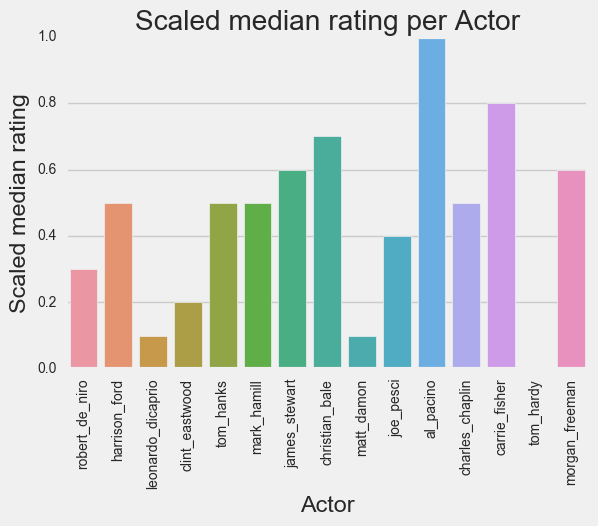

In [832]:
# Let's check out median rating per actor for the top 15 actors
# Note that there will be "double-counting" because some movies have more than one actor in the top 15
actor_rating = []
for i in top_15_actors:
    actor_rating.append([i,df4["imdbRating"][df4["Actor_"+i]==1].median()])

actor_rating = pd.DataFrame(actor_rating, columns=["Actor", "Median_rating"])

scaler2 = preprocessing.MinMaxScaler()
actor_rating["Scaled_rating"] = scaler2.fit_transform(actor_rating["Median_rating"].values.reshape(-1,1))

sns.barplot(x="Actor", y="Scaled_rating", data=actor_rating);
plt.title("Scaled median rating per Actor");
plt.ylabel("Scaled median rating");
plt.xticks(rotation="vertical");

In [758]:
vectorizer = feature_extraction.text.CountVectorizer(token_pattern=u'(?u)\w+.?\w?.? \w+')
directors_df = pd.DataFrame(vectorizer.fit_transform(df4["Director"]).todense(), columns = vectorizer.get_feature_names())

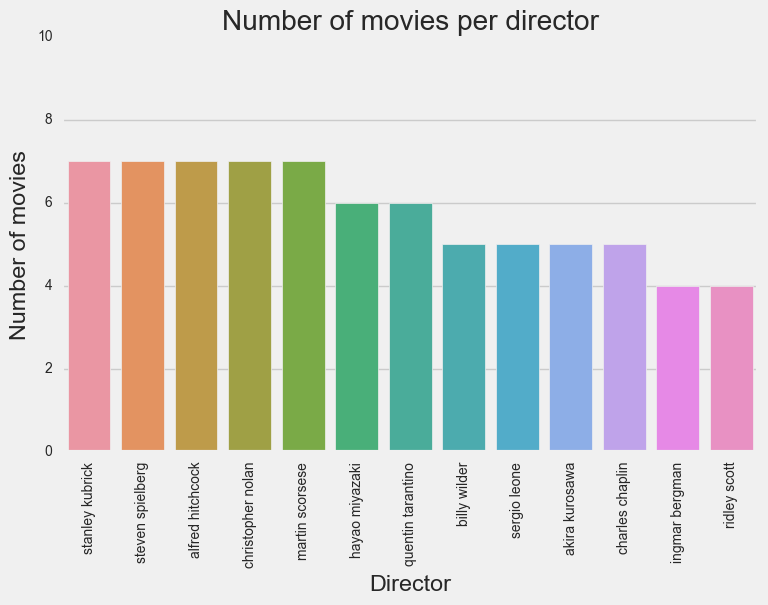

In [829]:
director_count = pd.DataFrame(directors_df.sum()).reset_index()
director_count.columns = ["Director", "Count"]
director_count.sort_values(by="Count", ascending=False, inplace=True)

more_than = director_count[director_count["Count"] > 3].reset_index(drop=True)
plt.subplots(figsize=(8,5));
sns.barplot(x="Director", y="Count", data=more_than);
plt.xticks(rotation="vertical");
plt.ylabel("Number of movies");
plt.title("Number of movies per director");
plt.ylim((0,10));

In [760]:
top_11_directors = directors_df.sum().sort_values(ascending=False).head(11).index
top_11_directors = [i.replace(" ", "_") for i in top_11_directors]
top_11_directors

[u'martin_scorsese',
 u'alfred_hitchcock',
 u'christopher_nolan',
 u'stanley_kubrick',
 u'steven_spielberg',
 u'quentin_tarantino',
 u'hayao_miyazaki',
 u'billy_wilder',
 u'akira_kurosawa',
 u'sergio_leone',
 u'charles_chaplin']

In [761]:
for i in top_11_directors:
    df4["Director_"+i.replace(" ", "_")] = directors_df.loc[:,i.replace("_", " ")]

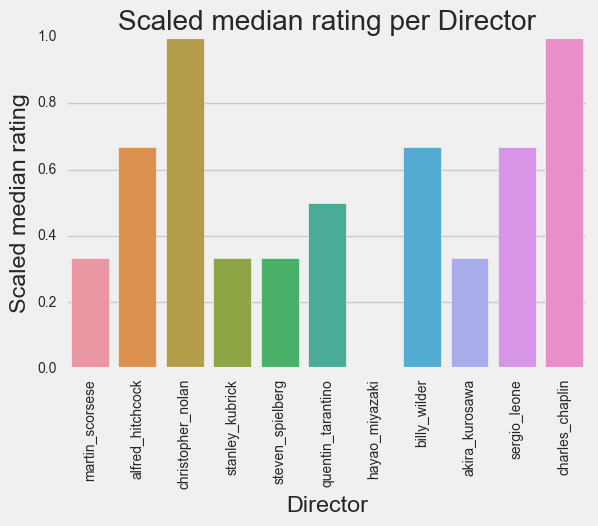

In [834]:
# Let's check out median rating per director for the top 11 directors
director_rating = []
for i in top_11_directors:
    director_rating.append([i,df4["imdbRating"][df4["Director_"+i]==1].median()])

director_rating = pd.DataFrame(director_rating, columns=["Director", "Median_rating"])

scaler2 = preprocessing.MinMaxScaler()
director_rating["Scaled_rating"] = scaler2.fit_transform(director_rating["Median_rating"].values.reshape(-1,1))

sns.barplot(x="Director", y="Scaled_rating", data=director_rating);
plt.title("Scaled median rating per Director");
plt.ylabel("Scaled median rating");
plt.xticks(rotation="vertical");

In [835]:
df4.head()

,rating_higher_8.5,imdbRating,imdbID,Title,Writer,Actors,Director,Plot,Metascore,Year,...,worst,writer,writes,wrong,wwi,wwii,year,years,york,young
0,1,8.5,tt2582802,Whiplash,Damien Chazelle,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,A promising young drummer enrolls at a cut-thr...,0.880238,1.237621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.204437
1,1,8.7,tt0047478,Seven Samurai,"Akira Kurosawa (screenplay), Shinobu Hashimoto...","Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"A veteran samurai, who has fallen on hard time...",1.140018,-1.240595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,1,8.5,tt0082971,Raiders of the Lost Ark,"Lawrence Kasdan (screenplay), George Lucas (st...","Harrison Ford, Karen Allen, Paul Freeman, Rona...",Steven Spielberg,The year is 1936. An archeology professor name...,0.802304,-0.125398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.132746,0.0,0.0,0.000000
3,0,8.2,tt0050212,The Bridge on the River Kwai,"Pierre Boulle (novel), Carl Foreman (screenpla...","William Holden, Alec Guinness, Jack Hawkins, S...",David Lean,After settling his differences with a Japanese...,-1.405824,-1.116684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0,8.1,tt0848228,The Avengers,"Joss Whedon (screenplay), Zak Penn (story), Jo...","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Joss Whedon,"Nick Fury is the director of S.H.I.E.L.D., an ...",0.386656,1.155014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [763]:
tfidf = feature_extraction.text.TfidfVectorizer(stop_words="english", ngram_range=(1,1), max_features=1000)

In [764]:
plot_df = pd.DataFrame(tfidf.fit_transform(df4["Plot"]).todense(), columns=tfidf.get_feature_names())

In [765]:
plot_df.head()

,000,15,30,abandoned,ability,able,accident,accidentally,accused,action,...,worst,writer,writes,wrong,wwi,wwii,year,years,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.204437
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.132746,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [766]:
df4 = pd.concat([df4,plot_df], axis=1)

In [767]:
df4.head()

,rating_higher_8.5,imdbRating,imdbID,Title,Writer,Actors,Director,Plot,Metascore,Year,...,worst,writer,writes,wrong,wwi,wwii,year,years,york,young
0,1,8.5,tt2582802,Whiplash,Damien Chazelle,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,A promising young drummer enrolls at a cut-thr...,0.880238,1.237621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.204437
1,1,8.7,tt0047478,Seven Samurai,"Akira Kurosawa (screenplay), Shinobu Hashimoto...","Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"A veteran samurai, who has fallen on hard time...",1.140018,-1.240595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,1,8.5,tt0082971,Raiders of the Lost Ark,"Lawrence Kasdan (screenplay), George Lucas (st...","Harrison Ford, Karen Allen, Paul Freeman, Rona...",Steven Spielberg,The year is 1936. An archeology professor name...,0.802304,-0.125398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.132746,0.0,0.0,0.000000
3,0,8.2,tt0050212,The Bridge on the River Kwai,"Pierre Boulle (novel), Carl Foreman (screenpla...","William Holden, Alec Guinness, Jack Hawkins, S...",David Lean,After settling his differences with a Japanese...,-1.405824,-1.116684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0,8.1,tt0848228,The Avengers,"Joss Whedon (screenplay), Zak Penn (story), Jo...","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Joss Whedon,"Nick Fury is the director of S.H.I.E.L.D., an ...",0.386656,1.155014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [768]:
df4.to_csv("imdb_model_text_features.csv", encoding="utf-8")

In [770]:
df4.iloc[:,:86].to_csv("imdb_tableau.csv", encoding="utf-8")

# Model: Define training set

In [848]:
df4 = pd.read_csv("imdb_model_text_features.csv", encoding="utf-8").iloc[:, 1:]

In [849]:
df4["imdbRating"].describe()

count    250.000000
mean       8.311600
std        0.231603
min        8.000000
25%        8.100000
50%        8.300000
75%        8.400000
max        9.300000
Name: imdbRating, dtype: float64

In [850]:
X = df4.iloc[:, 8:]
y = df4["imdbRating"]

In [851]:
X_train, X_test, yr_train, yr_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=77)

# Model: Fit and evaluate model
Bonus: How is model at risk of overfitting?

## Regression
Trying to predict an actual rating

In [852]:
gs = model_selection.GridSearchCV(ensemble.GradientBoostingRegressor(random_state=1),
                                  {"n_estimators": np.arange(50,100,10)},
                                  cv=5)
gs.fit(X_train,yr_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([50, 60, 70, 80, 90])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [853]:
gs.best_params_

{'n_estimators': 50}

In [854]:
gbr = gs.best_estimator_

In [855]:
y_pred = gbr.predict(X_test)

In [856]:
gbr.score(X_test, yr_test)

0.30472027532597834

In [857]:
metrics.mean_squared_error(yr_test, y_pred)

0.029385920310044819

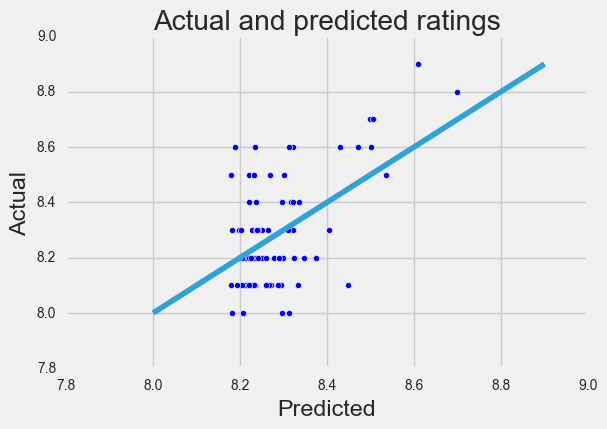

In [858]:
plt.plot([min(yr_test), max(yr_test)],[min(yr_test), max(yr_test)],'-');
plt.scatter(y_pred, yr_test);
plt.title("Actual and predicted ratings");
plt.xlabel("Predicted");
plt.ylabel("Actual");

## Classification

In [859]:
y_class = df4["rating_higher_8.5"]

In [863]:
X_train, X_test, yc_train, yc_test = model_selection.train_test_split(X, y_class, stratify=y_class, 
                                                                      test_size=0.3, random_state=77)

In [864]:
gs2 = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(random_state=1),
                                  {"n_estimators": np.arange(50,100,10),
                                   "min_samples_split": np.arange(5,10,1), 
                                   "min_samples_leaf": np.arange(5,10,1)},
                                  cv=5)
gs2.fit(X_train,yc_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([50, 60, 70, 80, 90]), 'min_samples_split': array([5, 6, 7, 8, 9]), 'min_samples_leaf': array([5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [865]:
gs2.best_params_

{'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 50}

In [866]:
gbc = gs2.best_estimator_

In [867]:
yc_pred = gbc.predict(X_test)

In [868]:
gbc.score(X_test, yc_test)

0.80000000000000004

In [870]:
conmat = metrics.confusion_matrix(yc_test, yc_pred)
conmat = pd.DataFrame(conmat)
conmat

,0,1
0,53,4
1,11,7


In [872]:
print metrics.classification_report(yc_test, yc_pred)

             precision    recall  f1-score   support

          0       0.83      0.93      0.88        57
          1       0.64      0.39      0.48        18

avg / total       0.78      0.80      0.78        75



AUC: 0.79044834308


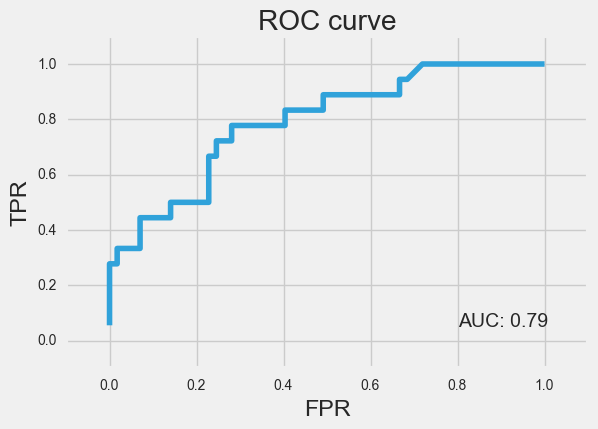

In [896]:
yc_score = gbc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(yc_test, yc_score)
print "AUC: {}".format(metrics.roc_auc_score(yc_test, yc_score))
plt.plot(fpr,tpr);
plt.title("ROC curve");
plt.ylim((-0.1, 1.1));
plt.xlim((-0.1, 1.1));
plt.xlabel("FPR");
plt.ylabel("TPR");
plt.text(0.8,0.05,"AUC: {:0.2f}".format(metrics.roc_auc_score(yc_test, yc_score)));

Classification does much better than regression.

## Feature selection

In [897]:
select = feature_selection.RFECV(gbc,cv=5)

In [898]:
select.fit(X_train, yc_train)

RFECV(cv=5,
   estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=5, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [899]:
select.support_

array([ True,  True,  True, ..., False, False,  True], dtype=bool)

In [900]:
X_train_new = select.transform(X_train)

In [901]:
gbc.fit(X_train_new, yc_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=6,
              min_samples_split=5, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False)

In [902]:
gbc.score(select.transform(X_test), yc_test)

0.77333333333333332

In [903]:
X_train_new.shape

(175, 25)

In [904]:
X_train.shape

(175, 1078)

In [907]:
yc_pred = gbc.predict(select.transform(X_test))

In [908]:
conmat = metrics.confusion_matrix(yc_test, yc_pred)
conmat = pd.DataFrame(conmat)
conmat

,0,1
0,51,6
1,11,7


In [909]:
print metrics.classification_report(yc_test, yc_pred)

             precision    recall  f1-score   support

          0       0.82      0.89      0.86        57
          1       0.54      0.39      0.45        18

avg / total       0.75      0.77      0.76        75



AUC: 0.807504873294


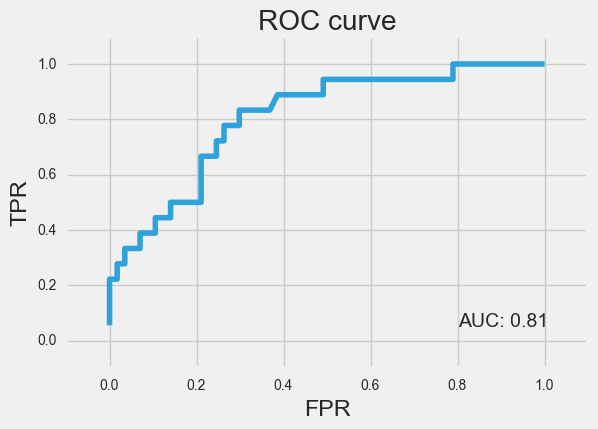

In [910]:
yc_score = gbc.predict_proba(select.transform(X_test))[:,1]
fpr, tpr, thresholds = metrics.roc_curve(yc_test, yc_score)
print "AUC: {}".format(metrics.roc_auc_score(yc_test, yc_score))
plt.plot(fpr,tpr);
plt.title("ROC curve");
plt.ylim((-0.1, 1.1));
plt.xlim((-0.1, 1.1));
plt.xlabel("FPR");
plt.ylabel("TPR");
plt.text(0.8,0.05,"AUC: {:0.2f}".format(metrics.roc_auc_score(yc_test, yc_score)));